In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import math 
import torch.nn.functional as F 
import numpy as np 


## Tokenization

Here we simply use english words as the dictionaries.

In [5]:
class Tokenizer:
    def __init__(self):
        self.word_to_id = {"I":0, "You":1, "like": 2, "do": 3, "not": 4, "coffee":5,"tea":6,".": 7}
        self.id_to_word = {v:k for k,v in self.word_to_id.items()}
    def encode(self, x):
        return [self.word_to_id[c] for c in x.split()]
    def decode(self, x):
        return ' '.join([self.id_to_word[c.item()] for c in x])


In [42]:

x1 = "I like"
tokenizer = Tokenizer()
x2 = "You do not like coffee ."
print("The tokenized result for string: %s is "%x1, tokenizer.encode(x1))
print("The tokenized result for string: %s is "%x2, tokenizer.encode(x2))


The tokenized result for string: I like is  [0, 2]
The tokenized result for string: You do not like coffee . is  [1, 3, 4, 2, 5, 7]


## Building the Neural Network 

### Embedding

mapping from higher dimensions (vocab size) to a lower dimension (embed dim)

embedding of the vocabs:
  tensor([[ 1.0772,  1.5293],
        [-0.4009, -0.2865],
        [-1.0777, -1.0076],
        [ 0.3878,  0.4832],
        [ 1.5837,  0.3763],
        [ 1.5163, -1.6267],
        [ 0.3829, -0.6081],
        [-0.6946,  0.1746]], grad_fn=<EmbeddingBackward0>)
embedding for I like is:
 tensor([[[ 1.0772,  1.5293],
         [-1.0777, -1.0076]]], grad_fn=<EmbeddingBackward0>)


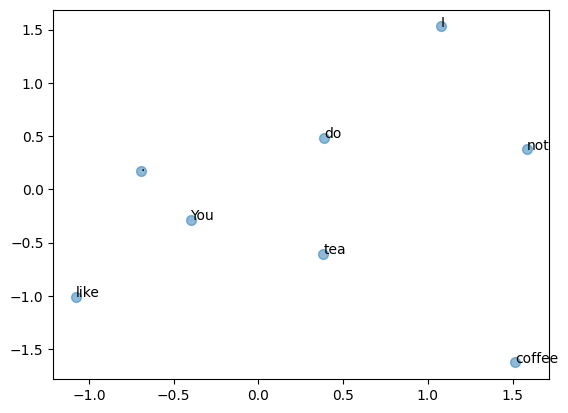

In [43]:

vocab = tokenizer.word_to_id.keys()
vocab_size = 8
embed_dim = 2
mlp_dim = 32

# Embedding Layer
fe = nn.Embedding(vocab_size, embed_dim)
x = torch.arange(vocab_size)
xe = fe(x)
print("embedding of the vocabs:\n ", xe)

x1e = fe(torch.tensor([tokenizer.encode(x1)]))
print("embedding for %s is:\n"%x1, x1e)

fig, ax = plt.subplots()

ax.scatter(xe.detach()[:,0], xe.detach()[:,1], s=50, alpha=0.5)
for i, txt in enumerate(vocab):
    ax.annotate(txt, (xe[i,0],xe[i,1]))


### Linear Transformation

The vector transforms to another vector via linear transformation.

The transformation changes state of the vector: for example, we can predict the next word by just see which word in the dictionary is closer than the transformed state.


0 I
1 like


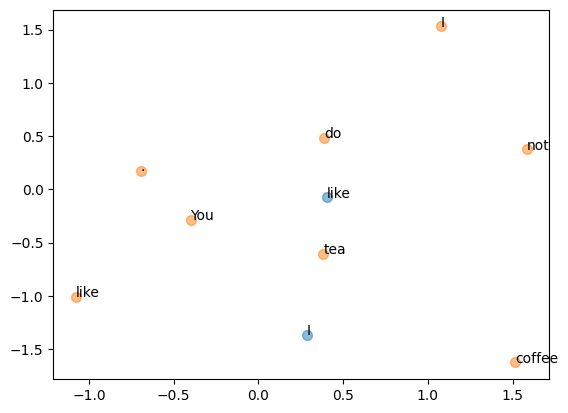

In [44]:
l = nn.Linear(embed_dim, embed_dim)
x1l = l(x1e)
fig, ax = plt.subplots()
ax.scatter(x1l.detach()[0][:,0], x1l.detach()[0][:,1], s=50, alpha=0.5)
for i, txt in enumerate(x1.split(" ")):
    print(i, txt)
    ax.annotate(txt, (x1l[0][i,0],x1l[0][i,1]))

# the original embedding
ax.scatter(xe.detach()[:,0], xe.detach()[:,1], s=50, alpha=0.5)
for i, txt in enumerate(vocab):
    ax.annotate(txt, (xe[i,0],xe[i,1]))



### Attention

attention coeff. without softmax and mask: 
 tensor([[[0.3274, 0.2832],
         [0.0024, 0.5162]]], grad_fn=<DivBackward0>)
attention coeff. without softmax after masking: 
 tensor([[[0.3274,   -inf],
         [0.0024, 0.5162]]], grad_fn=<AddBackward0>)
attention coeff. after softmax and masking: 
 tensor([[[1.0000, 0.0000],
         [0.3743, 0.6257]]], grad_fn=<SoftmaxBackward0>)
attention output:  tensor([[[-0.5992,  0.2246],
         [-0.6005, -0.5400]]], grad_fn=<UnsafeViewBackward0>)
0 I
1 like


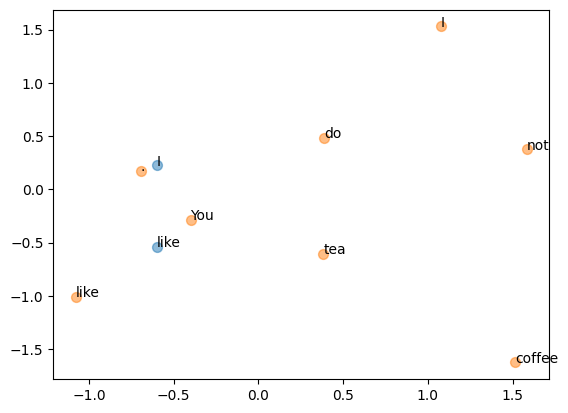

In [45]:
seqlen = len(x1.split(" "))
fv = nn.Linear(embed_dim, embed_dim)
fq = nn.Linear(embed_dim, embed_dim)
fk = nn.Linear(embed_dim, embed_dim)
q = fq(x1e)
k = fk(x1e)
v = fv(x1e)
scores = q @ k.transpose(-1,-2) / math.sqrt(embed_dim)
print("attention coeff. without softmax and mask: \n", scores)
mask = torch.full((seqlen, seqlen), float("-inf"))
mask = torch.triu(mask, diagonal=1)
scores = scores + mask
print("attention coeff. without softmax after masking: \n", scores)
scores = F.softmax(scores, dim=-1)
print("attention coeff. after softmax and masking: \n", scores)

attn_output = scores @ v
print("attention output: ", attn_output)

fig, ax = plt.subplots()
ax.scatter(attn_output.detach()[0][:,0], attn_output.detach()[0][:,1], s=50, alpha=0.5)
for i, txt in enumerate(x1.split(" ")):
    print(i, txt)
    ax.annotate(txt, (attn_output[0][i,0],attn_output[0][i,1]))
# the original embedding
ax.scatter(xe.detach()[:,0], xe.detach()[:,1], s=50, alpha=0.5)
for i, txt in enumerate(vocab):
    ax.annotate(txt, (xe[i,0],xe[i,1]))



masking matrix

In [46]:
mask

tensor([[0., -inf],
        [0., 0.]])

since we apply softmax, which includes $exp$ function, so $e^{-\infty}=0$

In [47]:
np.exp(-np.inf)

0.0

So actually the input (due to masking) is 
- "I"
- "I like"
- "I like coffee"
- "I like coffee ."

### MLP
It further applies linear transformation to the state vector in parallel.

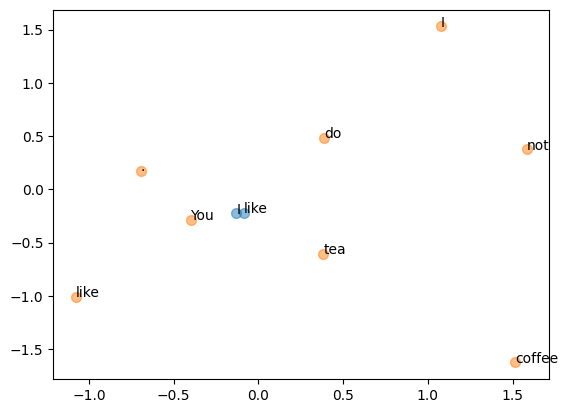

In [48]:
# MLP
fc = nn.Linear(embed_dim, mlp_dim)
fo = nn.Linear(mlp_dim, embed_dim)
mlp_output = fo(F.relu(fc(attn_output)))

# mlp output
fig, ax = plt.subplots()
ax.scatter(mlp_output.detach()[0][:,0], mlp_output.detach()[0][:,1], s=50, alpha=0.5)
for i, txt in enumerate(x1.split(" ")):
    ax.annotate(txt, (mlp_output[0][i,0],mlp_output[0][i,1]))
# the original embedding
ax.scatter(xe.detach()[:,0], xe.detach()[:,1], s=50, alpha=0.5)
for i, txt in enumerate(vocab):
    ax.annotate(txt, (xe[i,0],xe[i,1]))



### output projection
A final linear layer converting the vector back to the original dimension (vocab size dim).
- can share weight with the embedding layer
- output shape: [seqlen, vocab size]



In [49]:
# output projection
f_proj = nn.Linear(embed_dim, vocab_size)
f_proj.weight.data = fe.weight
logits = f_proj(mlp_output)
print("logits are: ", logits)

logits are:  tensor([[[-0.0776,  0.2695,  0.2986, -0.7418,  0.1354,  0.3805,  0.6317,
           0.5853],
         [-0.0176,  0.2494,  0.2426, -0.7208,  0.2092,  0.4359,  0.6442,
           0.5555]]], grad_fn=<ViewBackward0>)


### final output
logits are converted to probabilities via softmax

In [50]:
probs = F.softmax(logits, -1)
print("probabilities are: ", probs)



probabilities are:  tensor([[[0.0895, 0.1266, 0.1303, 0.0460, 0.1107, 0.1414, 0.1818, 0.1736],
         [0.0940, 0.1228, 0.1219, 0.0465, 0.1179, 0.1479, 0.1822, 0.1667]]],
       grad_fn=<SoftmaxBackward0>)


## Inference
- take the last row of the predicted probabilities
- sample from the multinomial distribution
- we can add the generated token to the input and do the same steps to get the next token

dict_keys(['I', 'You', 'like', 'do', 'not', 'coffee', 'tea', '.'])
torch.Size([1, 8])


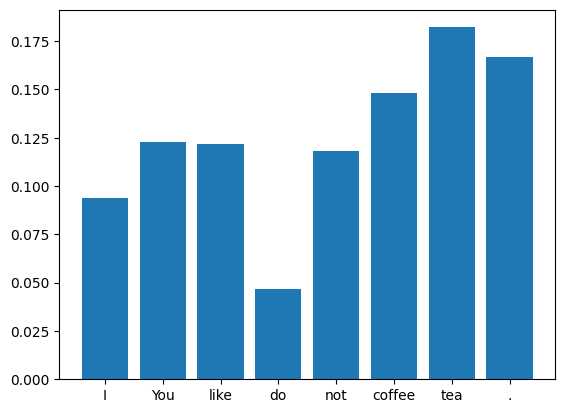

tensor([[0]])
Prediction after 'I like' is:  I


In [55]:
# inference
next_token_probs = probs[:,-1]
plt.figure()
print(vocab)
print(next_token_probs.shape)
plt.bar(vocab, next_token_probs[0].detach())
plt.show()
next_token = torch.multinomial(next_token_probs, num_samples=1)
print(next_token)
print("Prediction after '%s' is: "%x1, tokenizer.decode(next_token))



